# This notebook loads the rainfall forecast maps in the UK from 6 - 13 Feb 2020 during Storm Ciara/Dennis

#### Using Iris for NetCDF data load and processing

### Data acquired from Met Office MOGREPS-UK forecast

### For Met Office Climate Data Challenge 2022 Team 3A - Providing Historical Context to Extreme Events in Real-time


##### Correspondence: Timothy Lam t.lam@exeter.ac.uk

#### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os

import iris

import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat

import xarray as xr

import glob

#### Set data path

In [2]:
DATA_PATH = 'D:/UoE/Workshops/Met Office Climate Data Challenge 2022/Forecast Data/202002100300/'

#### Combine NetCDF files of different ensemble members

In [3]:
precip_path = xr.open_mfdataset(DATA_PATH + '202002100300_u1096_ng_ek*.nc', concat_dim = 'ensemble', combine = 'nested', decode_times = True)

In [6]:
print (precip_path)

<xarray.Dataset>
Dimensions:                  (bnds: 2, ensemble: 11, projection_x_coordinate: 548, projection_y_coordinate: 704, time: 54)
Coordinates:
  * time                     (time) datetime64[ns] 2020-02-08T04:00:00 ... 20...
  * projection_y_coordinate  (projection_y_coordinate) float32 -1.84e+05 ... ...
  * projection_x_coordinate  (projection_x_coordinate) float32 -2.38e+05 ... ...
    experiment_number        int16 0
    forecast_period          (time) int32 dask.array<chunksize=(54,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 2020-02-08T03:00:00
    realization              (ensemble) int32 0 1 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: bnds, ensemble
Data variables:
    amount_of_precipitation  (ensemble, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 54, 704, 548), meta=np.ndarray>
    transverse_mercator      (ensemble) int32 -2147483647 ... -2147483647
    time_bnds                (ensemble, time, bn

In [4]:
from dask.diagnostics import ProgressBar

time_to_netcdf = precip_path.to_netcdf (DATA_PATH + '202002100300.nc', compute = False)

with ProgressBar():
    results = time_to_netcdf.compute()

[########################################] | 100% Completed | 30.0s


#### Check variables of the NetCDF file

In [5]:
precip = iris.load('202002100300/202002100300.nc')
print (precip[0])

amount_of_precipitation / (mm)      (-- : 12; time: 54; projection_y_coordinate: 704; projection_x_coordinate: 548)
     Dimension coordinates:
          time                          -         x                            -                             -
          projection_y_coordinate       -         -                            x                             -
          projection_x_coordinate       -         -                            -                             x
     Auxiliary coordinates:
          realization                   x         -                            -                             -
          forecast_period               -         x                            -                             -
     Scalar coordinates:
          experiment_number: 0
          forecast_reference_time: 2020-02-10 03:00:00
     Attributes:
          Conventions: CF-1.7
          field_code: 61
          institution: Met Office
          nimrod_version: 2
          num_model_levels: 

C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\cf.py:1156: UserWarning: Ignoring variable 'time_bnds' referenced by variable 'time': Dimensions ('ensemble', 'time', 'bnds') do not span ('time',)
  warnings.warn(msg)
C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\cf.py:1156: UserWarning: Ignoring variable 'forecast_period_bnds' referenced by variable 'forecast_period': Dimensions ('ensemble', 'time', 'bnds') do not span ('time',)
  warnings.warn(msg)


In [6]:
precip_path = '202002100300/202002100300.nc'
precip = iris.load_cube(precip_path, 'amount_of_precipitation')
precip.coord('projection_y_coordinate').guess_bounds()
precip.coord('projection_x_coordinate').guess_bounds()


C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\cf.py:1156: UserWarning: Ignoring variable 'time_bnds' referenced by variable 'time': Dimensions ('ensemble', 'time', 'bnds') do not span ('time',)
  warnings.warn(msg)
C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\cf.py:1156: UserWarning: Ignoring variable 'forecast_period_bnds' referenced by variable 'forecast_period': Dimensions ('ensemble', 'time', 'bnds') do not span ('time',)
  warnings.warn(msg)


#### Choose the first ensemble member

In [7]:
ensemble_1 = precip [0]

In [8]:
print (ensemble_1)

amount_of_precipitation / (mm)      (time: 54; projection_y_coordinate: 704; projection_x_coordinate: 548)
     Dimension coordinates:
          time                           x                            -                             -
          projection_y_coordinate        -                            x                             -
          projection_x_coordinate        -                            -                             x
     Auxiliary coordinates:
          forecast_period                x                            -                             -
     Scalar coordinates:
          experiment_number: 0
          forecast_reference_time: 2020-02-10 03:00:00
          realization: 0
     Attributes:
          Conventions: CF-1.7
          field_code: 61
          institution: Met Office
          nimrod_version: 2
          num_model_levels: 1
          processing: accumulation or average
          source: ek
          title: Unknown


#### Create a rolling sum at every 24-hour timestep 

In [14]:
daily_sum_1 = ensemble_1.rolling_window ('time', iris.analysis.SUM, 24)

#### Plot data for the first time step

C:\Users\user\Anaconda3\lib\site-packages\iris\coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


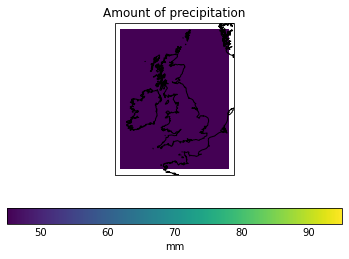

In [15]:
qplt.pcolormesh(daily_sum_1[10], vmin = 45, vmax = 95) 
plt.gca().coastlines()

So the remaining issues are as follows:

(1) Loop through different ensemble members - It is not possible to run the rollowing_window function to the precip cube with all ensemble members as a whole as it gives an error 'Empty tuples are not allowed in chunks'.

(2) Iterate to plot over different time steps

#### Create daily total

Alternatively, we can create daily total by aggregating the hourly data by day. 

In [9]:
coord_cat.add_day_of_month (precip, 'time', name='day')
coord_cat.add_month (precip, 'time', name='month')

In [10]:
print (precip)

amount_of_precipitation / (mm)      (-- : 12; time: 54; projection_y_coordinate: 704; projection_x_coordinate: 548)
     Dimension coordinates:
          time                          -         x                            -                             -
          projection_y_coordinate       -         -                            x                             -
          projection_x_coordinate       -         -                            -                             x
     Auxiliary coordinates:
          realization                   x         -                            -                             -
          day                           -         x                            -                             -
          forecast_period               -         x                            -                             -
          month                         -         x                            -                             -
     Scalar coordinates:
          experiment_numbe

In [11]:
# Aggregate by day
daily_sum = precip.aggregated_by(
    ['day'],
    iris.analysis.SUM)

In [12]:
# Check this worked
print (daily_sum)

amount_of_precipitation / (mm)      (-- : 12; time: 3; projection_y_coordinate: 704; projection_x_coordinate: 548)
     Dimension coordinates:
          time                          -         x                           -                             -
          projection_y_coordinate       -         -                           x                             -
          projection_x_coordinate       -         -                           -                             x
     Auxiliary coordinates:
          realization                   x         -                           -                             -
          day                           -         x                           -                             -
          forecast_period               -         x                           -                             -
          month                         -         x                           -                             -
     Scalar coordinates:
          experiment_number: 0
   

C:\Users\user\Anaconda3\lib\site-packages\iris\coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


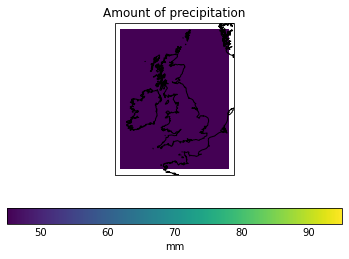

In [13]:
qplt.pcolormesh(daily_sum[0, 0], vmin = 45, vmax = 95) 
plt.gca().coastlines()